In [1]:
print("Hello World")
import os
import requests
import tarfile
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Hello World


/home/catalogn/.conda/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Subject

#### The objective of this mini-project is to train compare different SSL strategies by evaluating them on an Anomaly Detection downstream task. 

You will be using two anomaly detection datasets:

 • The MVTec AD datase (download from MVTec AD). Perform your exper
iments on AT LEAST the following categories: bottle, hazelnut, capsule,
 toothbrush.
 
 • The AutoVI dataset (download from AutoVI). Perform your experiments
 ONLY on the following category: engine wiring.

In [2]:
#Loading the datasets

def download_and_unzip(url, output_dir, zip_name="images.zip"):
    """
    Télécharge un fichier zip contenant des images et le décompresse dans un dossier.
    
    :param url: URL du fichier zip
    :param output_dir: Répertoire où les images seront décompressées
    :param zip_name: Nom temporaire pour le fichier zip téléchargé
    """
    # Download the zipfile on the wanted website
    print(f"Téléchargement du fichier depuis {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(zip_name, "wb") as file:
            file.write(response.content)
        print("Téléchargement terminé.")
    else:
        print("Erreur lors du téléchargement.")
        return

    # Create the output repo if necessary
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Unzip the file
    print(f"Décompression dans {output_dir}...")
    with zipfile.ZipFile(zip_name, "r") as zip_ref:
        zip_ref.extractall(output_dir)
    print("Décompression terminée.")

    # Delete the temporary zip file
    os.remove(zip_name)
    print("Fichier zip temporaire supprimé.")


def download_and_extract_tar(url, output_dir, tar_name="images.tar.gz"):
    """
    Télécharge un fichier TAR contenant des images et le décompresse dans un dossier.
    
    :param url: URL du fichier TAR
    :param output_dir: Répertoire où les images seront décompressées
    :param tar_name: Nom temporaire pour le fichier TAR téléchargé
    """
    # Download the TAR file on the wanted website
    print(f"Téléchargement du fichier depuis {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(tar_name, "wb") as file:
            file.write(response.content)
        print("Téléchargement terminé.")
    else:
        print("Erreur lors du téléchargement.")
        return

    # Create the output repo if necessary
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Untar the file
    print(f"Décompression dans {output_dir}...")
    if tarfile.is_tarfile(tar_name):
        with tarfile.open(tar_name, "r:*") as tar_ref:
            tar_ref.extractall(output_dir)
        print("Décompression terminée.")
    else:
        print(f"Le fichier {tar_name} n'est pas un fichier TAR valide.")
        return

    # Delete the temporary TAR file
    os.remove(tar_name)
    print("Fichier TAR temporaire supprimé.")

## Define the output directory   
output_dir = r"/home/catalogn/Documents/5A/HDDL/projets/projet3"

    
url = "https://zenodo.org/records/10459003/files/engine_wiring.zip?download=1" 
#download_and_unzip(url, output_dir)

url1 = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz"
#download_and_extract_tar(url1, output_dir)

url2 = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz"
#download_and_extract_tar(url2, output_dir)

url3 = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz"
#download_and_extract_tar(url3, output_dir)

url4 = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz"
#download_and_extract_tar(url4, output_dir)


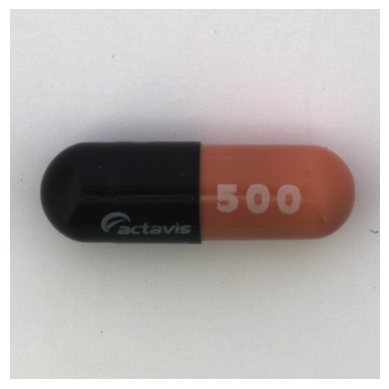

In [3]:
image = mpimg.imread('bottle/train/good/000.png')
image2 = mpimg.imread('capsule/train/good/000.png')
image3 = mpimg.imread('hazelnut/train/good/000.png')
plt.imshow(image2)
plt.axis('off')  # Optionnel : désactiver les axes
plt.show()

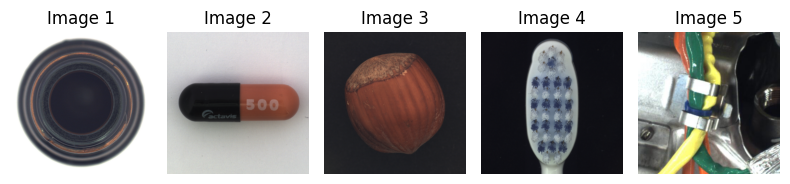

In [4]:
images = [
    mpimg.imread('bottle/train/good/000.png'),
    mpimg.imread('capsule/train/good/000.png'),
    mpimg.imread('hazelnut/train/good/000.png'),
    mpimg.imread('toothbrush/train/good/000.png'),
    mpimg.imread('engine_wiring/train/good/0000.png')
]

plt.figure(figsize=(8, 4))

for i, img in enumerate(images):
    plt.subplot(1, len(images), i + 1)  # 1 ligne, n colonnes, position i+1
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
import os
import shutil
def move_and_rename_images(src_dir, dest_dir):
    """
    Déplace et renomme les images des sous-dossiers dans un seul dossier cible.
    
    :param src_dir: Chemin du dossier contenant les sous-dossiers
    :param dest_dir: Chemin du dossier cible
    """
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)  # Crée le dossier cible s'il n'existe pas

    counter = 1  # Compteur pour différencier les fichiers
    for root, _, files in os.walk(src_dir):  # Parcourt récursivement les sous-dossiers
        for file in files:
            if file.endswith(".png"):  # Vérifie que c'est une image .png
                # Chemin complet de l'image source
                src_path = os.path.join(root, file)
                
                # Nouveau nom avec compteur
                new_name = f"{counter}.png"
                dest_path = os.path.join(dest_dir, new_name)
                
                # Déplace et renomme l'image
                shutil.move(src_path, dest_path)
                print(f"Moved: {src_path} -> {dest_path}")
                
                counter += 1  # Incrémente le compteur

# Exemple d'utilisation
src_directory = "engine_wiring/test/bad"
dest_directory = "engine_wiring/test/bad" 

#move_and_rename_images(src_directory, dest_directory)

In [6]:
data_dir = ['bottle', 'hazelnut', 'toothbrush', 'engine_wiring', 'capsule']

for data in data_dir: 
    print("######")
    print(data)
    # Définir les transformations des images (normalisation, redimensionnement, etc.)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionner les images
        transforms.ToTensor(),  # Convertir les images en tenseurs
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation standard pour les modèles pré-entraînés
    ])
    
    # Charger le dataset en spécifiant le dossier train ou test
    train_dataset = datasets.ImageFolder(root=f"{data}/train", transform=transform)
    test_dataset = datasets.ImageFolder(root=f"{data}/test", transform=transform)

    # Créer des variables distinctes pour les DataLoaders
    exec(f"{data}_train_dataset = train_dataset")
    exec(f"{data}_test_dataset = test_dataset")
    
    # Créer les DataLoaders
    batch_size = 32
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Créer des variables distinctes pour les DataLoaders
    exec(f"{data}_train_loader = train_loader")
    exec(f"{data}_test_loader = test_loader")

    
    # Vérifier le nombre d'images par dataset
    print(f"Nombre d'images pour le train : {len(train_dataset)}")
    print(f"Nombre d'images pour le test : {len(test_dataset)}")
    
    # Classes
    print(f"Classes détectées dans train : {train_dataset.classes}")
    print(f"Classes détectées dans test : {test_dataset.classes}")

######
bottle
Nombre d'images pour le train : 209
Nombre d'images pour le test : 83
Classes détectées dans train : ['good']
Classes détectées dans test : ['bad', 'good']
######
hazelnut
Nombre d'images pour le train : 391
Nombre d'images pour le test : 110
Classes détectées dans train : ['good']
Classes détectées dans test : ['bad', 'good']
######
toothbrush
Nombre d'images pour le train : 60
Nombre d'images pour le test : 42
Classes détectées dans train : ['good']
Classes détectées dans test : ['bad', 'good']
######
engine_wiring
Nombre d'images pour le train : 285
Nombre d'images pour le test : 607
Classes détectées dans train : ['good']
Classes détectées dans test : ['bad', 'good']
######
capsule
Nombre d'images pour le train : 219
Nombre d'images pour le test : 132
Classes détectées dans train : ['good']
Classes détectées dans test : ['bad', 'good']


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

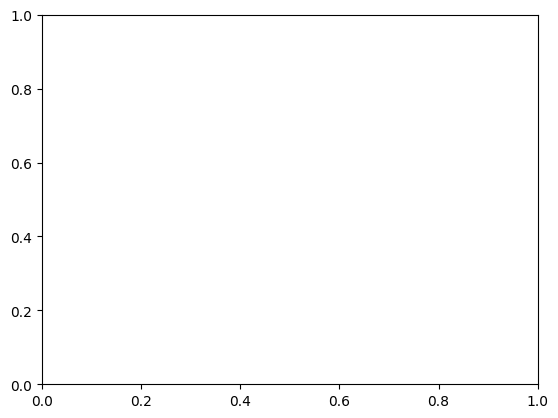

In [7]:
plt.hist(bottle_train_dataset)

On remarque que pour "engine_wiring" il y a beaucoup plus d'images dans le test que dans le train ce qui pourrait poser problème plus tard.

####  For each of the categories, you are asked to:
 
 • Train AT LEAST three different SSL models (masked autoencoder, constrastive model, inpainting model, colorizing model, siamese network...) using
 only the normal, training data.

• Use the model loss as an anomaly score and evaluate the anomaly score’s
 discriminative power by plotting the ROC curve and the AUROC metric.


#### Points will be awarding according to the following criteria:

• The notebook is clearly written, contains markdown cells with all necessary
 explanations, and the code cells are well commented.

• Explanation and arguments of the different model choices, architecture choices
 and hyper-parameter choices (which need not be the same for all categories!).

• Clear comparison and visualization of the results (plots, tables...)
 Extra bonus points will be awarded according to the following criteria:

    • Originality of the model choice (i.e. choosing models different than those
     seen during the TP)

    • Theobtained AUROC metrics will be compared between different teams and
     bonus points will be given according to the rankings

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=128):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=2, padding=1),  # 4x4 -> 2x2
            nn.ReLU(),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=3):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)

In [9]:
def train_ssl_model(model, 
                    train_loader, 
                    test_loader, 
                    criterion,
                    optimizer,
                    device=device,
                    epochs=5):

    for epoch in range(epochs):
        model.to(device)
        model.train()
        total_train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            output, _ = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(device)
                output, _ = model(images)
                val_loss = criterion(output, images)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(test_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")
    
    return model.encoder

In [10]:
class ColorizationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(ColorizationModel, self).__init__()
        self.encoder = Encoder(latent_dim=latent_dim, in_channels=1)  # Input grayscale
        self.decoder = Decoder(latent_dim=latent_dim, out_channels=3)  # Predict RGB

    def forward(self, x):
        grayscale_x = transforms.Grayscale()(x)  # Convert RGB to Grayscale
        z = self.encoder(grayscale_x)
        return self.decoder(z), grayscale_x

In [11]:
colorization_model = ColorizationModel(latent_dim=128)
colorization_encoder = train_ssl_model(colorization_model, 
                                       hazelnut_train_loader, 
                                       hazelnut_test_loader, 
                                       criterion=nn.MSELoss(), 
                                       optimizer=optim.Adam(colorization_model.parameters(), lr=0.001)
                                       )

Epoch 1/5, Train Loss: 0.0581, Avg Val Loss: 0.0565
Epoch 2/5, Train Loss: 0.0487, Avg Val Loss: 0.0558
Epoch 3/5, Train Loss: 0.0514, Avg Val Loss: 0.0565
Epoch 4/5, Train Loss: 0.0512, Avg Val Loss: 0.0565
Epoch 5/5, Train Loss: 0.0511, Avg Val Loss: 0.0565


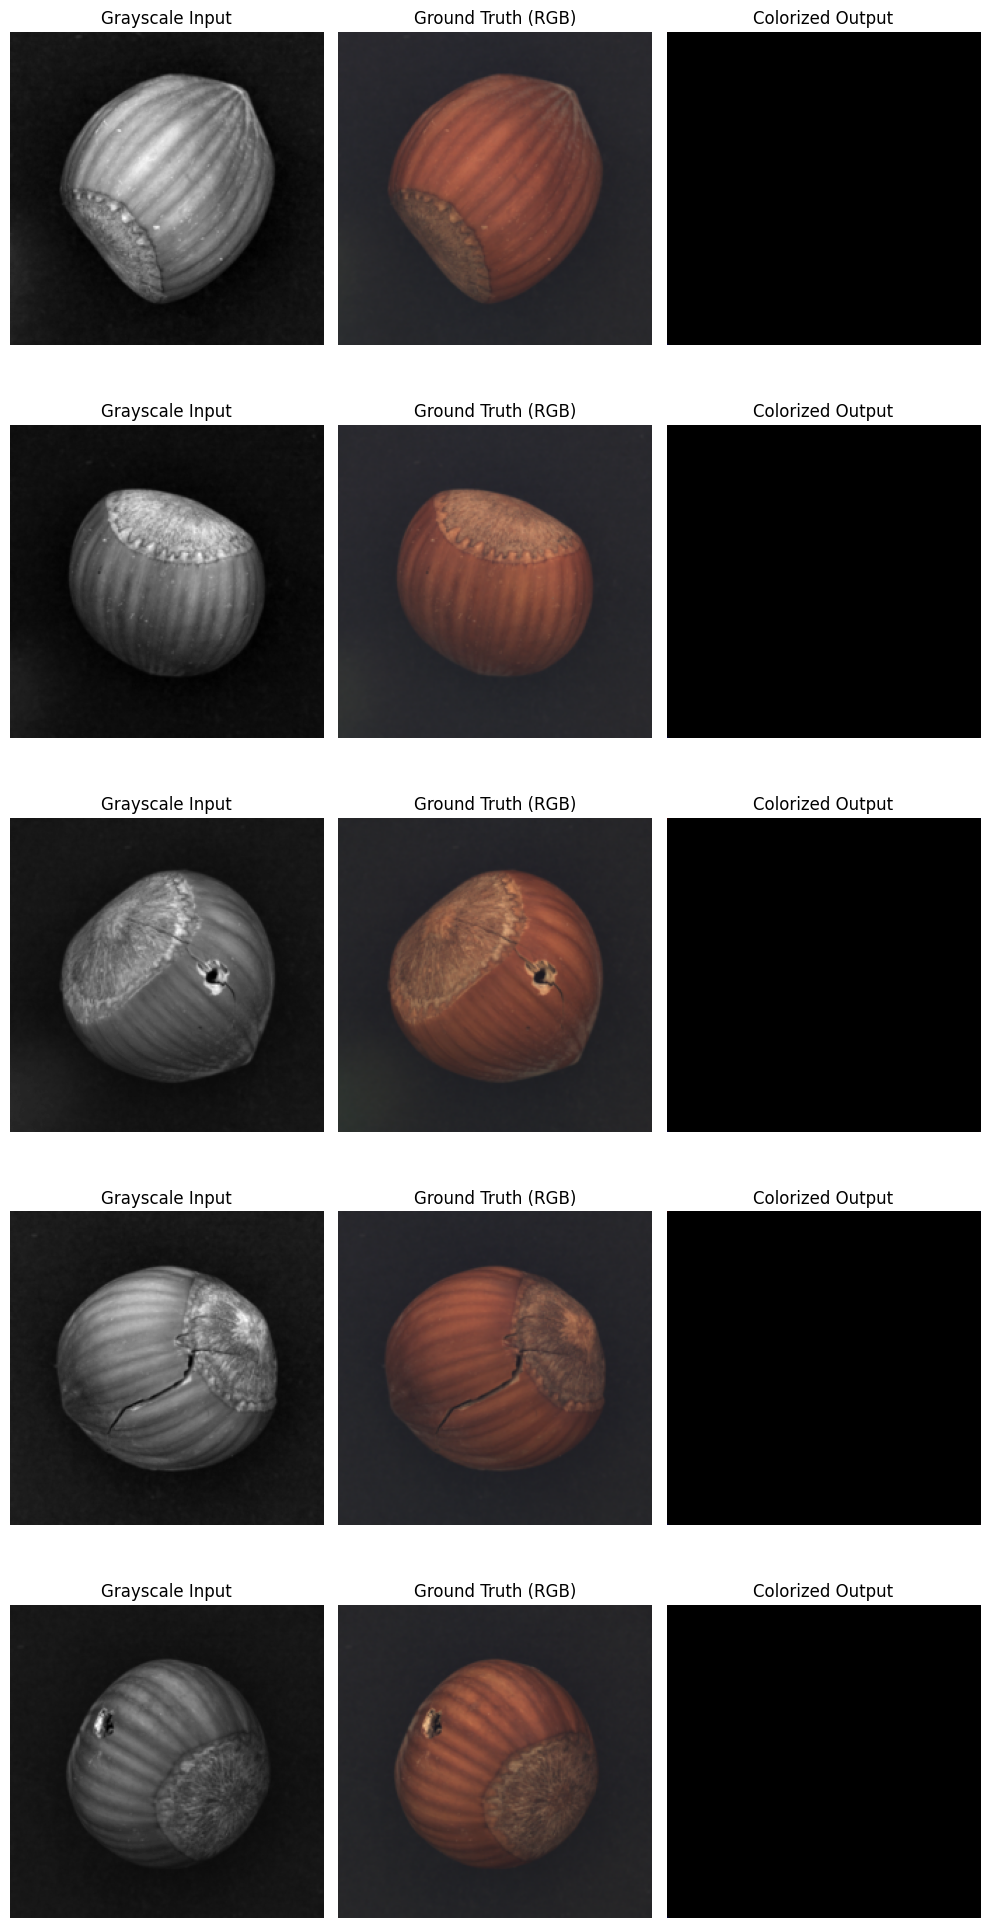

In [12]:
import random

# Visualize colorization on random test images

def visualize_reconstructions(model, data_loader, device, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Convert the DataLoader to a list to randomly sample images
    dataset = list(data_loader.dataset)

    # Randomly select `num_images` images from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)
    random_images = [dataset[i][0] for i in random_indices]  # Extract only the images, ignoring labels

    # Stack the images into a batch
    images = torch.stack(random_images)

    # Move images to the specified device
    images = images.to(device)
    
    # Run the grayscale images through the colorization model
    with torch.no_grad():
        reconstructed_images, perturbed_images = model(images)
    
    # Move images back to CPU for visualization
    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()
    perturbed_images = perturbed_images.cpu()
    
    # Plot the grayscale, ground truth, and colorized images
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 4))
    for i in range(num_images):
        # Grayscale input
        axes[i, 0].imshow(perturbed_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title("Grayscale Input")
        axes[i, 0].axis('off')
        
        # Ground truth (original RGB image)
        axes[i, 1].imshow(images[i].permute(1, 2, 0))
        axes[i, 1].set_title("Ground Truth (RGB)")
        axes[i, 1].axis('off')
        
        # Colorized output from the model
        axes[i, 2].imshow(reconstructed_images[i].permute(1, 2, 0))
        axes[i, 2].set_title("Colorized Output")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize colorization on random test images
visualize_reconstructions(colorization_model, hazelnut_test_loader, device)